### Human Emotion Rating Data EDA

In [3]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from pathlib import Path



In [4]:
#Load Data
exp1_rating = pd.read_csv('../data/human-data/exp1_preprocessed.csv')  
exp2_rating = pd.read_csv('../data/human-data/exp2_preprocessed.csv')  
exp3_rating = pd.read_csv('../data/human-data/exp3_preprocessed.csv')  


In [26]:
#picking out emotion rating and combine two dataframes
cols = ['Participant_Private','Image Name', 'Image Category', 'Emotion', 'Emo_Rating']
exp1_rating_filtered = exp1_rating[cols].copy()
exp2_rating_filtered = exp2_rating[cols].copy()
exp3_rating_filtered = exp3_rating[cols].copy()
human_df = pd.concat([exp1_rating_filtered, exp2_rating_filtered,exp3_rating_filtered], axis=0, ignore_index=True)

human_df.rename(columns={
    'Participant_Private': 'participant',
    'Image Name':         'image',
    'Image Category':     'image_category',
    'Emo_Rating':         'emo_rating'
}, inplace=True)



In [8]:
human_df

,participant,Image Name,Image Category,Emotion,Emo_Rating
0,8685107.0,140abstract.jpg,leslie,Anger,78.0
1,8685107.0,141woman.jpg,leslie,Anger,25.0
2,8685107.0,145banjo.jpg,leslie,Anger,0.0
3,8685107.0,151guitar.jpg,leslie,Anger,60.0
4,8685107.0,170abstract.jpg,leslie,Anger,60.0
...,...,...,...,...,...
125072,13458459.0,la-jolla-arbor.jpg,impressionism,Surprise,11.0
125073,13458459.0,lake-in-the-mountains-1899.jpg,impressionism,Surprise,12.0
125074,13458459.0,not_detected_189365.jpg,abstract,Surprise,11.0
125075,13458459.0,not_detected_189367.jpg,abstract,Surprise,10.0


### Exploratory Data Analysis (focus on exp3 for now)


In [27]:
#check number of unique participants 
human_df['participant'].nunique(), human_df['image'].nunique(), human_df['image_category'].nunique(), human_df['Emotion'].nunique()


(222, 971, 5, 6)

<Axes: xlabel='Emotion', ylabel='emo_rating'>

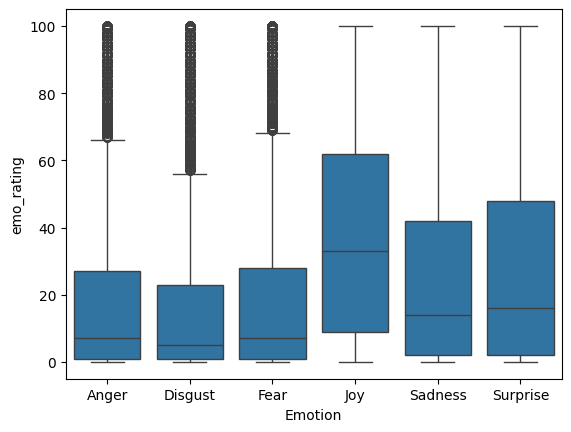

In [28]:
sns.boxplot(x='Emotion', y='emo_rating', data=human_df)


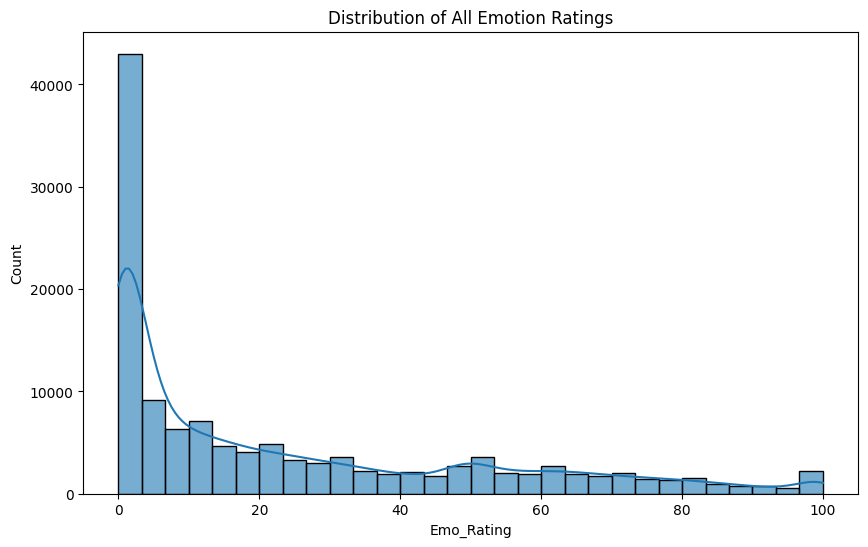

In [29]:
plt.figure(figsize=(10,6))
# Histogram of all ratings
sns.histplot(human_df['emo_rating'], bins=30, kde=True, alpha=0.6)

plt.title('Distribution of All Emotion Ratings')
plt.xlabel('Emo_Rating')
plt.ylabel('Count')
plt.show()


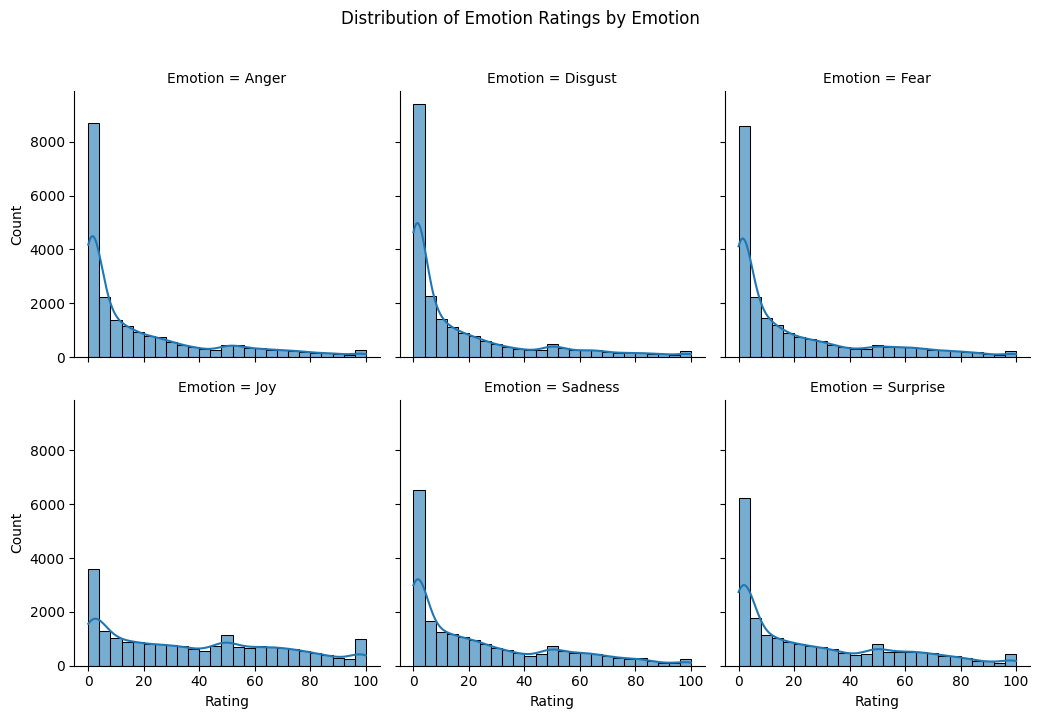

In [30]:
# Set up a FacetGrid: one panel per emotion
g = sns.FacetGrid(human_df, col='Emotion', col_wrap=3, sharex=True, sharey=True, height=3.5)
g.map(sns.histplot, 'emo_rating', bins=25, kde=True, alpha=0.6)

# Labels & layout
g.set_axis_labels('Rating', 'Count')
g.fig.suptitle('Distribution of Emotion Ratings by Emotion', y=1.02)
plt.tight_layout()
plt.show()


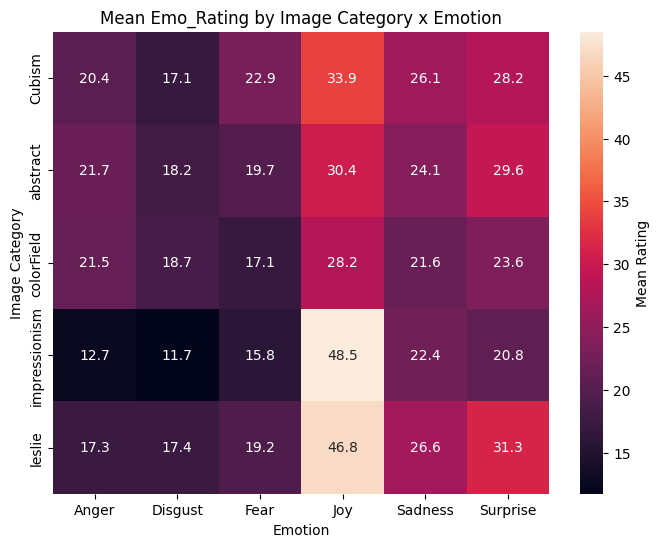

In [31]:
# Pivot to get mean ratings
pivot_cat_em = (
    human_df
    .groupby(['image_category','Emotion'])['emo_rating']
    .mean()
    .unstack()
)

plt.figure(figsize=(8,6))
sns.heatmap(
    pivot_cat_em,
    annot=True, fmt=".1f",
    cbar_kws={'label':'Mean Rating'}
)
plt.title('Mean Emo_Rating by Image Category x Emotion')
plt.ylabel('Image Category')
plt.xlabel('Emotion')
plt.show()


In [51]:
img_avg = human_df.groupby(['image','Emotion'])['emo_rating'].mean().unstack()
corr = img_avg.corr()
corr

Emotion,Anger,Disgust,Fear,Joy,Sadness,Surprise
Emotion,,,,,,
Anger,1.000000,0.556202,0.557881,-0.492909,0.417421,0.433760
Disgust,0.556202,1.000000,0.525868,-0.534178,0.455908,0.327687
Fear,0.557881,0.525868,1.000000,-0.408880,0.573530,0.363654
Joy,-0.492909,-0.534178,-0.408880,1.000000,-0.386128,-0.054124
Sadness,0.417421,0.455908,0.573530,-0.386128,1.000000,0.157711
Surprise,0.433760,0.327687,0.363654,-0.054124,0.157711,1.000000


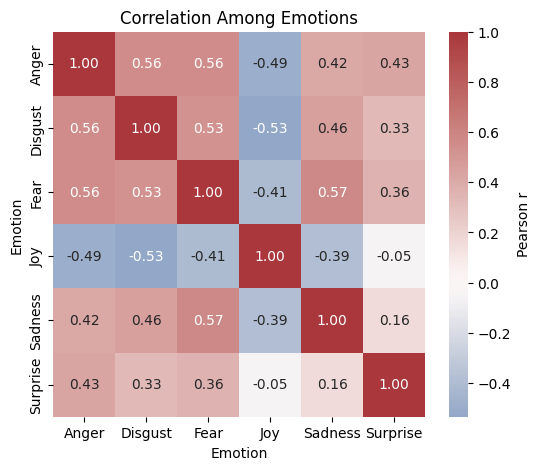

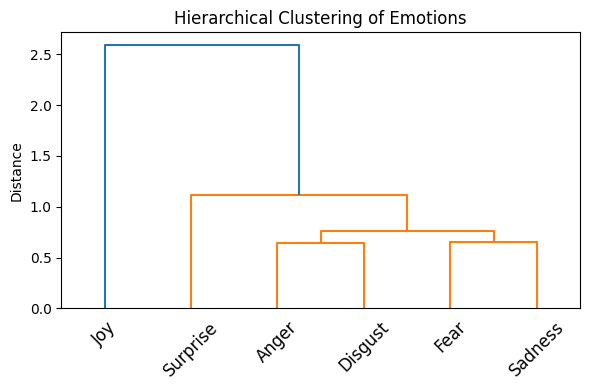

In [33]:

# 4.1 Compute per-image emotion profiles
img_profiles = (
    human_df
    .groupby(['image','Emotion'])['emo_rating']
    .mean()
    .unstack()
)

# 4.2 Correlation matrix of the 6 emotions
corr = img_profiles.corr()

# 4.3 Heatmap of emotion correlations
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", 
            cmap='vlag', center=0,
            cbar_kws={'label':'Pearson r'})
plt.title('Correlation Among Emotions')
plt.show()

# 4.4 Dendrogram clustering of emotions
linkage = sch.linkage(corr, method='average')
plt.figure(figsize=(6,4))
sch.dendrogram(linkage, labels=corr.columns, leaf_rotation=45)
plt.title('Hierarchical Clustering of Emotions')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()


### Import LLM data

In [53]:
# DF to have one row per image, with all emotion ratings
data_dir = Path("../output/analysis_output")
emotions = ["joy", "sadness", "fear", "anger", "disgust", "surprise", "liking"]

categories = {p.stem.split("_", 1)[1]
              for p in data_dir.glob("*.csv")}

merged_by_cat = []

for cat in categories:
    df_cat = None
    for emo in emotions:
        path = data_dir / f"{emo}_{cat}.csv"
        if not path.exists():
            continue  
        df = pd.read_csv(path)

        df = df.rename(columns={
            "Emo_Rating":      f"{emo}_rating",
            "Explanation":      f"{emo}_explanation"
        })

        df = df[["image", "image_category",
                 f"{emo}_rating", f"{emo}_explanation"]]
        if df_cat is None:
            df_cat = df
        else:
            df_cat = df_cat.merge(
                df,
                on=["image", "image_category"],
                how="outer"
            )
    merged_by_cat.append(df_cat)

# 3. Stack all categories into one DataFrame
llm_score_per_image = pd.concat(merged_by_cat, ignore_index=True)


In [54]:
all_dfs = []

for csv_path in data_dir.glob("*.csv"):
    # infer emotion key from filename
    emo = csv_path.stem.split("_", 1)[0].lower()

    df = pd.read_csv(csv_path)
    # rename the dynamic columns → generic names
    df = df.rename(columns={
        f"{emo}_rating":       "emo_rating",
        f"{emo}_explanation":  "emo_explanation"
    })
    # add the Emotion column
    df["Emotion"] = emo.capitalize()

    # select & reorder the five columns you want
    df = df[[
        "image",
        "image_category",
        "Emotion",
        "emo_rating",
        "emo_explanation"
    ]]
    all_dfs.append(df)

# concatenate everything into one long table
llm_concat_ratings = pd.concat(all_dfs, ignore_index=True)

#concat_ratings.to_csv("../data/merged_emotions_concatenated.csv", index=False)



In [55]:
llm_df = llm_concat_ratings[llm_concat_ratings['Emotion'] != 'Liking'].copy()

#### Exploratory on LLM data

<Axes: xlabel='Emotion', ylabel='emo_rating'>

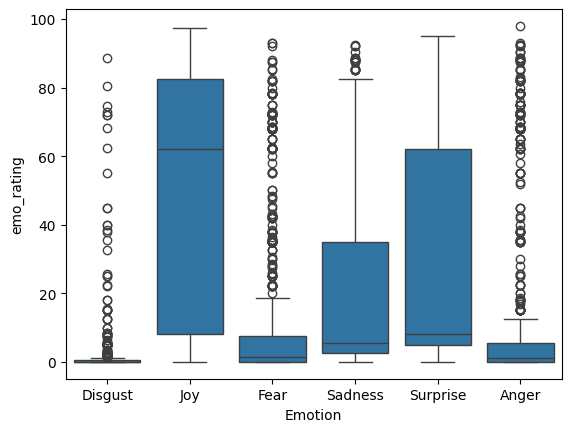

In [56]:
sns.boxplot(x='Emotion', y='emo_rating', data=llm_df)


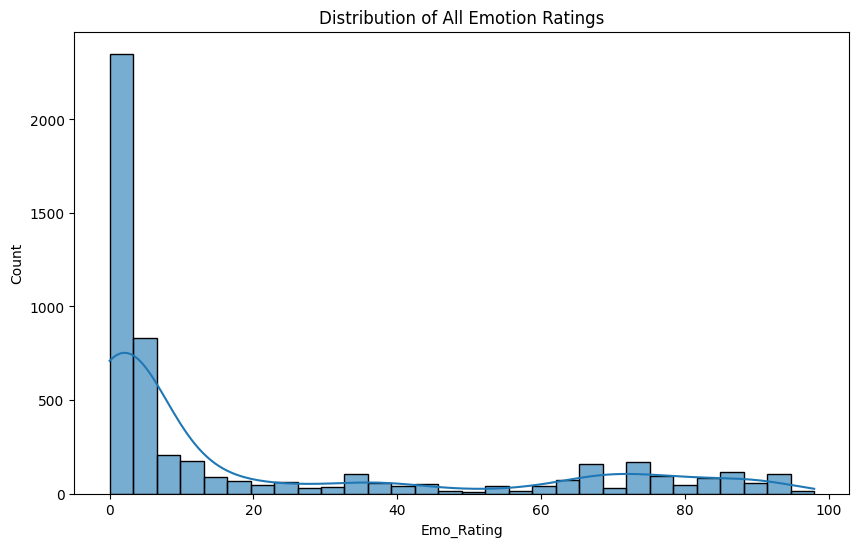

In [58]:
plt.figure(figsize=(10,6))
# Histogram of all ratings
sns.histplot(llm_df['emo_rating'], bins=30, kde=True, alpha=0.6)

plt.title('Distribution of All Emotion Ratings')
plt.xlabel('Emo_Rating')
plt.ylabel('Count')
plt.show()

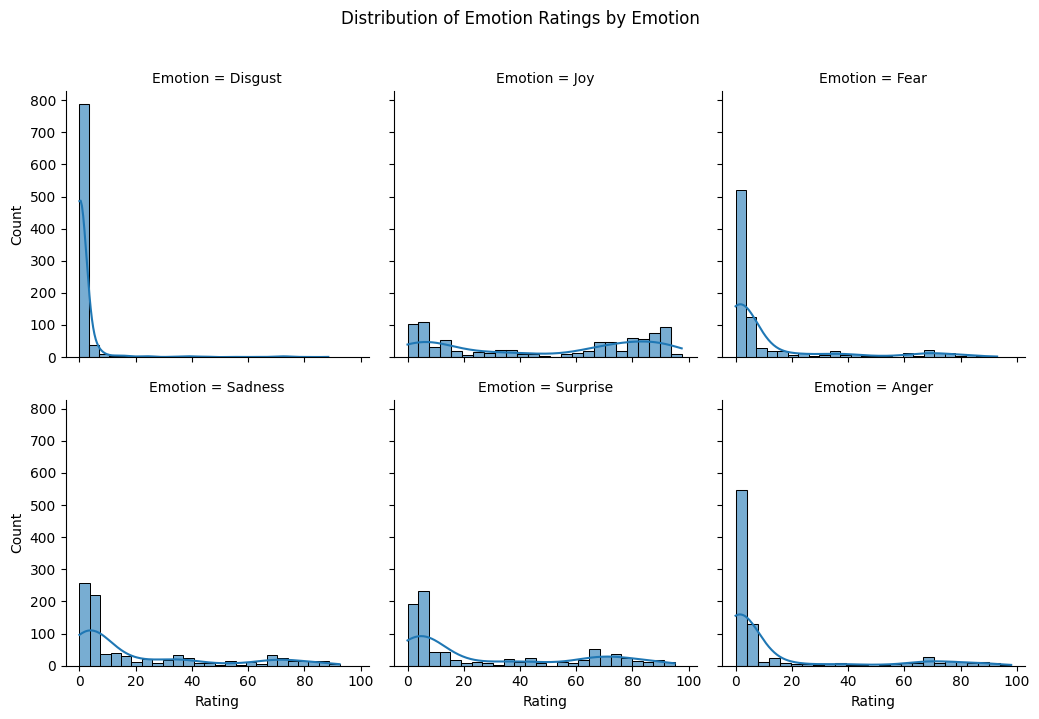

In [59]:
# Set up a FacetGrid: one panel per emotion
g = sns.FacetGrid(llm_df, col='Emotion', col_wrap=3, sharex=True, sharey=True, height=3.5)
g.map(sns.histplot, 'emo_rating', bins=25, kde=True, alpha=0.6)

# Labels & layout
g.set_axis_labels('Rating', 'Count')
g.fig.suptitle('Distribution of Emotion Ratings by Emotion', y=1.02)
plt.tight_layout()
plt.show()


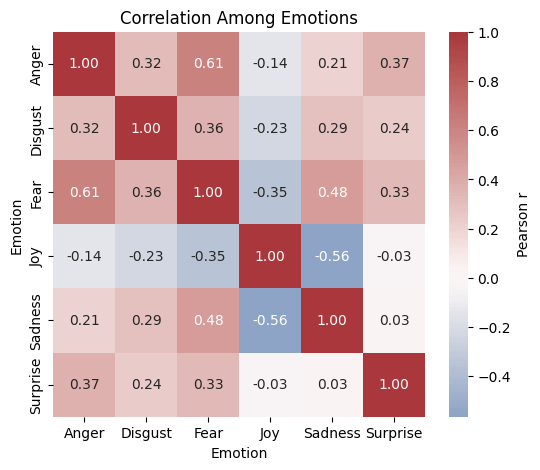

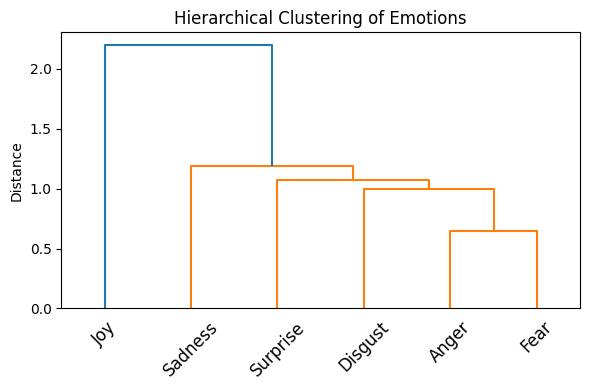

In [60]:
# 4.1 Compute per-image emotion profiles
img_profiles = (
    llm_df
    .groupby(['image','Emotion'])['emo_rating']
    .mean()
    .unstack()
)

# 4.2 Correlation matrix of the 6 emotions
corr = img_profiles.corr()

# 4.3 Heatmap of emotion correlations
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", 
            cmap='vlag', center=0,
            cbar_kws={'label':'Pearson r'})
plt.title('Correlation Among Emotions')
plt.show()

# 4.4 Dendrogram clustering of emotions
linkage = sch.linkage(corr, method='average')
plt.figure(figsize=(6,4))
sch.dendrogram(linkage, labels=corr.columns, leaf_rotation=45)
plt.title('Hierarchical Clustering of Emotions')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

### ------------------------END-----------------------------

In [118]:
#mat_data = loadmat('../data/human-data/image_mean_rating.mat') I don't care about this for now

In [119]:
print(mat_data.keys())

NameError: name 'mat_data' is not defined

In [ ]:
# Extract and squeeze data (MATLAB often returns extra dimensions)
image_names = mat_data['image_names'].squeeze()
image_categories = mat_data['image_categories'].squeeze()
mean_scores = mat_data['mean_score'].squeeze()

# Optional: decode strings if needed
if isinstance(image_names[0], np.ndarray):
    image_names = [name[0] for name in image_names]
if isinstance(image_categories[0], np.ndarray):
    image_categories = [cat[0] for cat in image_categories]

# Create DataFrame
rating_df = pd.DataFrame({
    'image_name': image_names,
    'image_category': image_categories,
    'mean_score': mean_scores
})


In [ ]:
#aesthetic rating from Kyo, one score per painting
rating_df

,image_name,image_category,mean_score
0,a-fisherman-s-cottage.jpg,impressionism,2.783133
1,a-grey-day-carmel.jpg,impressionism,3.098361
2,a-misty-morning.jpg,impressionism,3.023438
3,a-mother-and-son-seated-by-a-wall-before-the-s...,impressionism,2.593220
4,a-spanish-barracks-1906.jpg,impressionism,2.633333
...,...,...,...
821,woman-and-bird-1930.jpg,Cubism,NaN
822,woman-on-a-balcony-1914.jpg,Cubism,2.368852
823,woman-with-mandolin-1925.jpg,Cubism,NaN
824,workbox.jpg,Cubism,2.409836
